In [5]:
# 加权重
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
exp_npzfile="/home/zhonghua/data/Dataset_Filted/Experiment/2022/1e10_V03_2022_dataset_optimized.npz" 
exp_data = np.load(exp_npzfile, allow_pickle=True)
exp_hitsE = exp_data["hitsE"]
exp_hitsM = exp_data["hitsM"]
exp_params = exp_data["params"]
exp_param_names=exp_data["param_names"]
print(exp_param_names)
print(exp_params[1])
exp_param_names=exp_data["param_names"]

probs_data = np.load("/home/zhonghua/Filt_Event/transformer/1e10_Ponly_optimized/exp_probs_optimized.npz", allow_pickle=True)
probs = probs_data["probs"]
indices = probs_data["indices"]
new_indices=[]
for n in range(len(exp_params)):
    prob=probs[n]
    if (prob<0.05):
        new_indices.append(n)
print(len(new_indices))

['label' 'weight' 'R_ue' 'R_mean' 'Eage' 'trueE' 'recE' 'rec_x' 'rec_y'
 'rec_theta' 'rec_phi']
[-1 1 -6.471570037337265 42.941285717798394 1.1512045860290527 -1.0
 1.9676754474639893 -592.833984375 15.813830375671387 0.47368597984313965
 3.230376958847046]
884


Loaded 8664 events
✅ Loaded hWeight from ROOT


100%|██████████| 8664/8664 [00:00<00:00, 45049.11it/s]


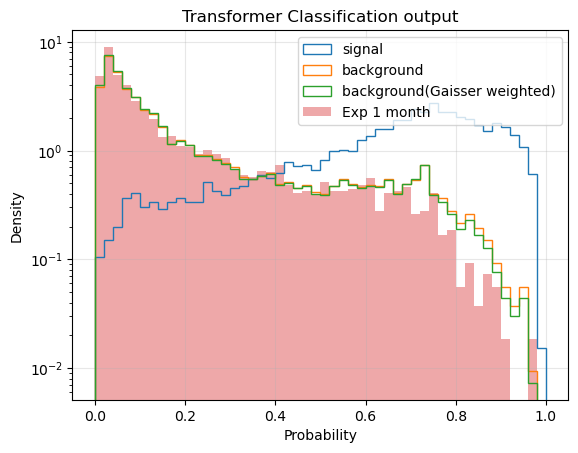

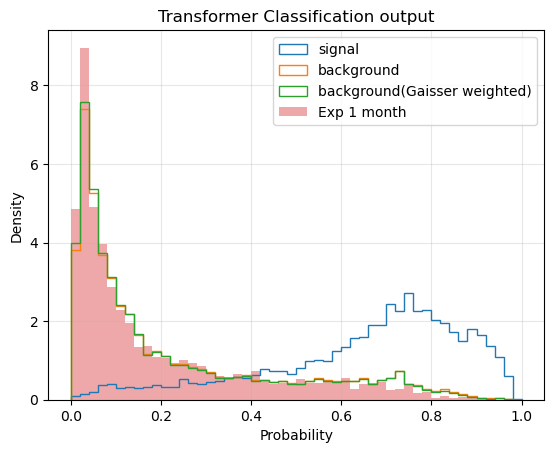

In [ ]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# 1. 加载 npz 数据
# -----------------------------
data=np.load("/home/zhonghua/Filt_Event/transformer/1e10_Ponly_optimized/val_preds_best.npz", allow_pickle=True)
sig=data["sig"]
bkg=data["bkg"]
indices=data["indices"]
exp_npzfile = "/home/zhonghua/data/Dataset_Filted/1e10_V03/sampled_Ponly_1e10_V03_dataset_optimized.npz"
exp_data = np.load(exp_npzfile, allow_pickle=True)
exp_params = exp_data["params"][indices]
exp_param_names = exp_data["param_names"]

# 提取字段索引
idx_recE = np.where(exp_param_names == "recE")[0][0]
idx_recTheta = np.where(exp_param_names == "rec_theta")[0][0]
idx_parID = np.where(exp_param_names == "label")[0][0]

recE = exp_params[:, idx_recE]
recTheta = exp_params[:, idx_recTheta]  # 单位应为度
parID = exp_params[:, idx_parID]
sig_params=exp_params[parID == 43]
bkg_params=exp_params[parID != 43]

print(f"Loaded {len(recE)} events")

# -----------------------------
# 2. 打开 exposure.root 读取 hWeight
# -----------------------------
rootfile = "/home/zhonghua/data/exposure.root"

with uproot.open(rootfile) as f:
    hWeight = f["hWeight"]
    edges_E = hWeight.axes[0].edges()  # Energy bin edges
    edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
    weights_2d = hWeight.values()

print("✅ Loaded hWeight from ROOT")

# -----------------------------
# 3. 定义能量与天顶角的映射函数
# -----------------------------
# -----------------------------
# 4. 根据 recE, rec_theta 获取对应权重
# -----------------------------
nEbin = len(edges_E) - 1
nTbin = len(edges_Zen) - 1

event_weights = np.zeros(len(recE))

for i in tqdm(range(len(recE))):
    E = recE[i]
    th = recTheta[i]*180/np.pi  # 转为度
    if E <= 0: 
        continue
    

    # 计算能量 bin
    logE = np.log10(E)
    j = int(np.floor(logE))
    if j < 0 or j >= nEbin:
        continue  # 超出能量范围

    # 计算天顶角 bin
    i_zen = np.digitize(th, edges_Zen) - 1
    if i_zen < 0 or i_zen >= nTbin:
        continue

    # 从 2D 权重直方图取出
    event_weights[i] = weights_2d[j, i_zen]

exp_params = np.array(exp_params)
exp_params[:,1] = event_weights

sig_weight = exp_params[parID == 43][:,1]
bkg_weight = exp_params[parID != 43][:,1]

# plt.hist(exp_params[:,1], bins=50, )
# plt.show()



data=np.load("/home/zhonghua/Filt_Event/transformer/1e10_Ponly_optimized/exp_probs_optimized.npz", allow_pickle=True)
probs=data["probs"]

plt.hist(sig, bins=50,  label='signal', density=True, histtype='step', range=(0,1))
plt.hist(bkg, bins=50,  label='background', density=True, histtype='step', range=(0,1), )
plt.hist(bkg, bins=50,  label='background(Gaisser weighted)', density=True, histtype='step', range=(0,1), weights=bkg_weight)
plt.hist(probs, bins=50,  label='Exp 1 month', density=True, range=(0,1), alpha=0.4)
# plt.hist(probs, bins=50, weights=1/event_weights, label='Exp_weight', density=True, range=(0,1), alpha=0.54)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.title("Transformer Classification output")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.show()

plt.hist(sig, bins=50,  label='signal', density=True, histtype='step', range=(0,1))
plt.hist(bkg, bins=50,  label='background', density=True, histtype='step', range=(0,1), )
plt.hist(bkg, bins=50,  label='background(Gaisser weighted)', density=True, histtype='step', range=(0,1), weights=bkg_weight)
plt.hist(probs, bins=50,  label='Exp 1 month', density=True, range=(0,1), alpha=0.4)
# plt.hist(probs, bins=50, weights=1/event_weights, label='Exp_weight', density=True, range=(0,1), alpha=0.54)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
# plt.yscale('log')
plt.title("Transformer Classification output")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.show()

In [ ]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
# 打开权重文件  所有
file_path = "/home/zhonghua/data/Dataset_Filted/Proton_all_energies.root"
with uproot.open(file_path) as f:
    tree = f["Weights"]
    print(tree.keys()) 
    evt       = tree["evt"].array(library="np")
    weight    = tree["weight"].array(library="np")
    E_GeV     = tree["E_GeV"].array(library="np")
    theta_rad = tree["theta_rad"].array(library="np")
    theta_deg = tree["theta_deg"].array(library="np")


In [ ]:
print(f"Entries: {len(evt):,}")
print(f"One day --Sum of weights: {np.sum(weight):.2f}({np.sum(weight):.5e})")
print(f"One year--Sum of weights: {np.sum(weight)*365:.5e}")

E_logTeV= np.log10(E_GeV/1e3)
plt.hist(E_logTeV, bins=50, label="E_logTeV", log=False)
plt.xlabel("Energy (TeV)")
plt.ylabel("Counts")
plt.legend()
plt.show()

weight_min=np.min(weight)
weight_max=np.max(weight)
print(f"Weight min: {weight_min}, max: {weight_max},")
plt.hist(weight, bins=100, label="Weight", log=True)
plt.xlabel("Weight")
plt.ylabel("Counts")
plt.legend()
plt.show()

Entries: 3,640,612
One day--Sum of weights: 1663182728.33(1.66318e+09)
One year--Sum of weights: 6.07062e+11


In [51]:
# 实际实验上 90296   89575  90455
oneday=1.75103e+08
oneyear=1.75103e+08*365
print(f"实际一天：{oneday:5e}")
print(f"实际一年：{oneyear:5e}")

实际一天：1.751030e+08
实际一年：6.391260e+10


63912595000.0